In [2]:
from scripts.utils import *
from scripts.new_model import *
import matplotlib.pyplot as plt

In [3]:
with open('data/schizo_genes_filtered.txt', 'r') as file:
    schizo_genes = [line.strip() for line in file]

FileNotFoundError: [Errno 2] No such file or directory: 'data/schizo_genes_filtered.txt'

In [4]:
with open("genept/GenePT_gene_embedding_ada_text.pickle", "rb") as f:
    embedding_dict = pickle.load(f)


In [4]:
from sklearn.decomposition import PCA
import numpy as np

# Convert embeddings to a numpy array
embeddings_matrix = np.array([embedding_dict[gene] for gene in schizo_genes if gene in embedding_dict])

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(embeddings_matrix)

# Print or visualize the results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)


Explained variance ratio: [0.04842688 0.03937589]
Principal components shape: (324, 2)


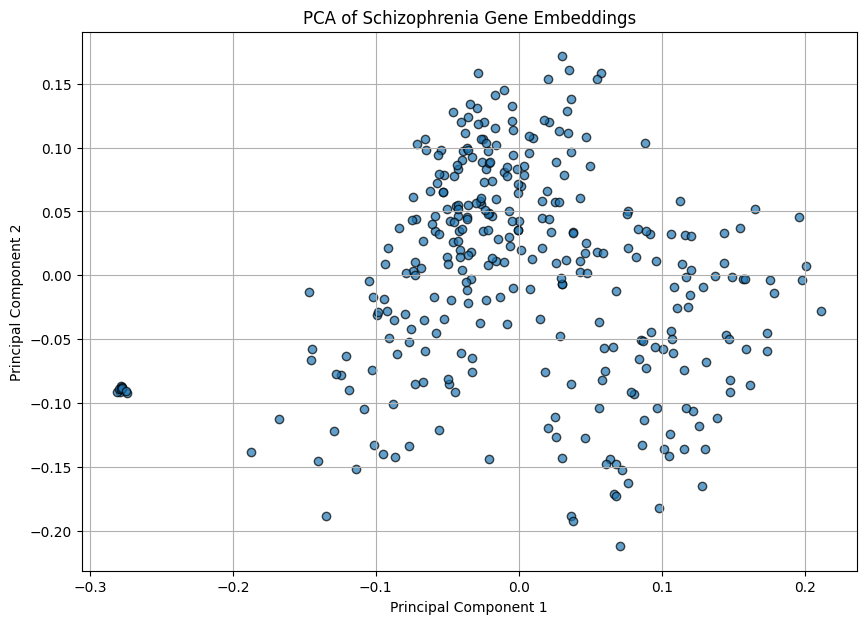

In [5]:
# Scatter plot of the two principal components
plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7, edgecolors='k')
plt.title('PCA of Schizophrenia Gene Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [8]:

model = MLP(input_dim=3072, hidden_dim=256)
model.load_state_dict(torch.load("models/mlp_epistasis.pt"))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

gene1 = schizo_genes[0]
gene2 = schizo_genes[1]

predict_epistatic(model, gene1, gene2, embedding_dict)

odict_keys(['ffm.0.weight', 'ffm.0.bias', 'ffm.3.weight', 'ffm.3.bias'])


NameError: name 'schizo_genes' is not defined

In [17]:
from itertools import combinations
from scipy.spatial.distance import euclidean

def plot_all_gene_combos_distance_vs_prediction(schizo_genes, principal_components, model, embedding_dict):
    distances = []
    prediction_scores = []
    gene_pairs = []

    device = torch.device("cpu")
    model.to(device)    

    # Iterate over all combinations of gene pairs
    for gene1, gene2 in combinations(schizo_genes, 2):
        if gene1 in embedding_dict and gene2 in embedding_dict:
            # Get the PCA coordinates of the two genes
            gene1_pca = principal_components[schizo_genes.index(gene1)]
            gene2_pca = principal_components[schizo_genes.index(gene2)]

            # Calculate the Euclidean distance between the two genes in PCA space
            distance = euclidean(gene1_pca, gene2_pca)

            # Predict the epistatic interaction score using the model
            gene1_embedding = embedding_dict[gene1]
            gene2_embedding = embedding_dict[gene2]
            input_vector = np.concatenate([gene1_embedding, gene2_embedding]).reshape(1, -1)
            prediction_score = model(torch.tensor(input_vector, dtype=torch.float32)).item()

            # Store the results
            distances.append(distance)
            prediction_scores.append(prediction_score)
            gene_pairs.append((gene1, gene2))

    # Plot the distance vs prediction score
    plt.figure(figsize=(10, 7))
    plt.scatter(distances, prediction_scores, alpha=0.7, color='blue')
    plt.title('Distance vs Prediction Score for All Gene Pairs')
    plt.xlabel('Distance in PCA Space')
    plt.ylabel('Prediction Score')
    plt.grid(True)
    plt.show()

    return distances, prediction_scores, gene_pairs

In [18]:
plot_all_gene_combos_distance_vs_prediction(schizo_genes, principal_components, model, embedding_dict)

IndexError: index 324 is out of bounds for axis 0 with size 324